In [1]:
import tensorflow as tf
import datetime, os
#hide tf logs 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'} 
#0 (default) shows all, 1 to filter out INFO logs, 2 to additionally filter out WARNING logs, and 3 to additionally filter out ERROR logs
import scipy.optimize
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import seaborn as sns 
import codecs, json
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 

# generates same random numbers each time
np.random.seed(1234)
tf.random.set_seed(1234)

print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.9.1


# *Data Prep*

Training and Testing data is prepared from the solution file

In [2]:
## Data Import
K_real = np.load('./K_tx_real_d_one.npy') # Values of K(t,x)
Q_real = np.load('./Q_15minutes.npy') # Input Matrix of Model
f_real = Q_real[:,1] # Inflow Rate
v_real = Q_real[:,3] # Average Speed
pi_real = np.load('./pitilde_15minutes.npy') # Values of pi(t,x)

In [3]:
pi_real.shape

(150, 2016)

Text(0, 0.5, 'Remaining Trip Distance (miles)')

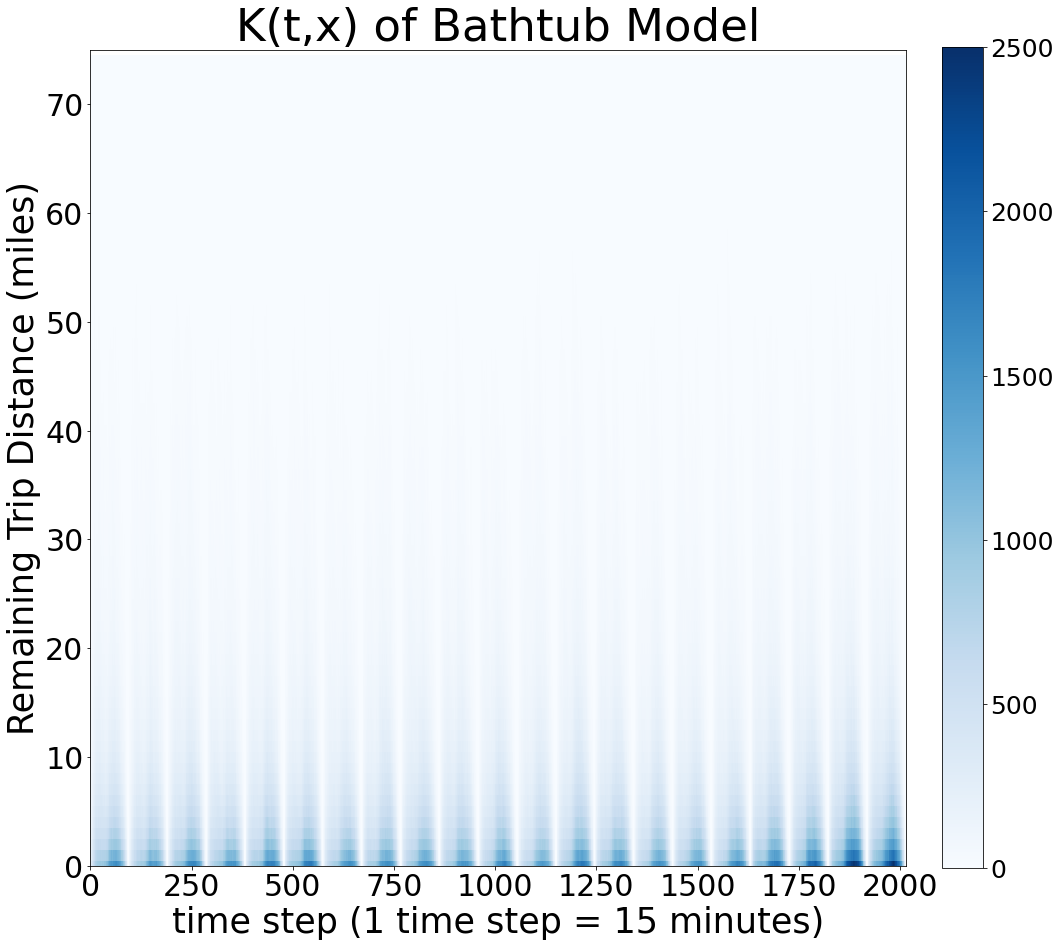

In [4]:
K_array = np.array(K_real[:,0:len(K_real[0])])
fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.T, cmap = 'Blues', interpolation='nearest')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,len(K_real[0])])
plt.clim(0, 2500) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title('K(t,x) of Bathtub Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (miles)', fontsize=35)

In [5]:
## Scale
N_timestep = 24*21*4 # 24 hours * 21 days * 15 minutes = total timestep
N_diststep = 75 # 1 distance step = 1 mile
Size_diststep = 1 # unit: miles
N_trainingdays = 0 # Set zero (0)
N_training = 24*4*N_trainingdays # Training data is all


## Normalization [0,1]
x = np.arange(0,int(N_diststep/Size_diststep))[:,None]   # x: step of remaining distance
t = np.arange(0,N_timestep)[:,None]    # Time step 
usol = K_real.transpose() [:,N_training:]     # real value of K(t,x) ==> Target Variable
usol_max = usol.max()

## Normalization [0,1]
x = (x - x.min()) / (x.max() - x.min())
t = (t - t.min()) / (t.max() - t.min())
f_real = (f_real - usol.min()) / (usol.max() - usol.min())  # usol과 같은 dimension이어야 함. 단위 같기 때문.
v_real = (v_real - v_real.min()) / (v_real.max() - v_real.min())
usol = (usol - usol.min()) / (usol.max()-usol.min())

X, T = np.meshgrid(x,t)                     # makes 2 arrays X and T such that u(X[i],T[j])=usol[i][j] are a tuple


multiplier_dist = int(N_diststep/Size_diststep)-1
multiplier_time = N_timestep-1
multiplier_u = usol_max
print('multiplier distance = ', multiplier_dist)
print('multiplier time = ', multiplier_time)
print('usol max = ', usol_max)

multiplier distance =  74
multiplier time =  2015
usol max =  2500


In [6]:
Size_diststep = 5 # unit: miles
Size_timestep = 2 # 2: 30min, 3: 60min
size_input = int(N_diststep/Size_diststep)*int(N_timestep/Size_timestep) # Total number of grid points
# size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
N_u = int(size_input*0.2) # Total number of data points for 'u' ==> Training data from grid points
N_f = N_u*2 #Total number of collocation (auxiliary) points 
alpha = 0.5 # weights of loss

print('size input = ', size_input)
print('N_u = ', N_u)
print('N_f = ', N_f)

size input =  15120
N_u =  3024
N_f =  6048


In [7]:
# # Previous version (before Aug 30)
# size_input = int(N_diststep/Size_diststep)*N_timestep # All domain
# # size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
# N_u = int(size_input*0.5) #Total number of data points for 'u'
# N_f = N_u*2 #Total number of collocation points 
# alpha = 0.5

# print('size input = ', size_input)
# print('N_u = ', N_u)
# print('N_f = ', N_f)

# *Grid Data*

We prepare the grid data to compare against the solution produced by the PINN.

In [8]:
''' X_u_test = [X[i],T[i]] [25600,2] for interpolation'''
X_u_grid = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

# Domain bounds
lb = X_u_grid[0]  # [-1. 0.]
ub = X_u_grid[-1] # [1.  0.99]

'''
   Fortran Style ('F') flatten,stacked column wise!
   u = [c1 
        c2
        .
        .
        cn]

   u =  [25600x1] 
'''
u_grid = usol.flatten('F')[:,None] 

# *Training Data* (All domain)


The boundary conditions serve as the test data for the PINN and the collocation points are generated using **Latin Hypercube Sampling**

In [9]:
def trainingdata(N_u,N_f):

#     '''Boundary Conditions'''

#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 0  
#     leftedge_x = np.hstack((X[0,:][:,None], T[0,:][:,None])) #L1
#     leftedge_u = usol[:,0][:,None]
    
#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 2015  
#     rightedge_x = np.hstack((X[0,:][:,None], T[-1,:][:,None])) #L1
#     rightedge_u = usol[:,-1][:,None]

#     #Boundary Condition x = 9 (135 miles) and 0 =< t =<2015
#     topedge_x = np.hstack((X[:,-1][:,None], T[:,0][:,None])) #L3
#     topedge_u = usol[-1,:][:,None]
        
#     #Boundary Condition x = 0 and 0 =< t =<2015
#     bottomedge_x = np.hstack((X[:,0][:,None], T[:,0][:,None])) #L2
#     bottomedge_u = usol[0,:][:,None]
    
#     #Boundary Condition x = 5 (25 miles) and 0 =< t =<2015
#     midedge_x = np.hstack((X[:,5][:,None], T[:,0][:,None])) #L3
#     midedge_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 10 (50 miles) and 0 =< t =<2015
#     midedge1_x = np.hstack((X[:,10][:,None], T[:,0][:,None])) #L3
#     midedge1_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 15 (75 miles) and 0 =< t =<2015
#     midedge2_x = np.hstack((X[:,15][:,None], T[:,0][:,None])) #L3
#     midedge2_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 20 (100 miles) and 0 =< t =<2015
#     midedge3_x = np.hstack((X[:,20][:,None], T[:,0][:,None])) #L3
#     midedge3_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 25 (125 miles) and 0 =< t =<2015
#     midedge4_x = np.hstack((X[:,25][:,None], T[:,0][:,None])) #L3
#     midedge4_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 2 and 0 =< t =<2015
#     bottomedge_x_2 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_2 = usol[2,:][:,None]
    
#     #Boundary Condition x = 1 and 0 =< t =<2015
#     bottomedge_x_1 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_1 = usol[1,:][:,None]


#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x, midedge1_x, midedge2_x, midedge3_x, midedge4_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u, midedge1_u, midedge2_u, midedge3_u, midedge4_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([bottomedge_x, bottomedge_x_1, bottomedge_x_2]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, bottomedge_u_1, bottomedge_u_2])   #corresponding u [4042,]
    
#     all_X_u_train = np.vstack([bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, topedge_u])   #corresponding u [4042,]

    all_X_u_train = np.hstack((X.T[range(0,N_diststep,Size_diststep)][:,range(0,N_timestep,Size_timestep)].flatten()[:,None],T.T[range(0,N_diststep,Size_diststep)][:,range(0,N_timestep,Size_timestep)].flatten()[:,None]))
    all_u_train = usol[range(0,N_diststep,Size_diststep)][:,range(0,N_timestep,Size_timestep)].flatten()[:,None]
    
    #choose random N_u points for training
    np.random.seed(1234)
    train_idx = np.random.choice(all_X_u_train.shape[0], N_u, replace=False) # ID of training data
    test_idx = np.delete(np.arange(size_input), train_idx) # ID of testing data
    
    # Training Data
    X_u_train = all_X_u_train[train_idx, :] #choose indices from  set 'idx' (x,t)
    u_train = all_u_train[train_idx,:]      #choose corresponding u
    
    # Testing Data
    X_u_test = all_X_u_train[test_idx, :]
    u_test = all_u_train[test_idx,:]

    '''Collocation Points'''

    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
#     X_f_train = np.rint(lb + (ub-lb)*lhs(2,N_f))
    X_f_train = (lb + (ub-lb)*lhs(2,N_f))
#     X_f_train = np.unique(X_f_train, axis=0).astype(int) # 중복된 것 없앰
    X_f_train = np.vstack((X_f_train, X_u_train)) # append training points to collocation points 
    
    f_t = f_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    pi_tx = pi_real[np.int0(X_f_train*multiplier_dist)[:,0],np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    v_t = v_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]

    return X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx

In [10]:
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)

In [11]:
X_u_train.shape

(3024, 2)

In [12]:
X_u_test.shape

(12096, 2)

In [13]:
X_u_train

array([[0.47297297, 0.86054591],
       [0.33783784, 0.00794045],
       [0.67567568, 0.41389578],
       ...,
       [0.40540541, 0.96277916],
       [0.74324324, 0.81191067],
       [0.81081081, 0.03970223]])

# **PINN**

Generate a **PINN** of L hidden layers, each with n neurons. 

Initialization: ***Xavier***

Activation: *tanh (x)*

In [14]:
class Sequentialmodel(tf.Module): 
    def __init__(self, layers, name=None):
       
        self.W = []  #Weights and biases
        self.parameters = 0 #total number of parameters
        
        for i in range(len(layers)-1):
            
            input_dim = layers[i]
            output_dim = layers[i+1]
            
            #Xavier standard deviation 
            std_dv = np.sqrt((2.0/(input_dim + output_dim)))

            #weights = normal distribution * Xavier standard deviation + 0
            w = tf.random.normal([input_dim, output_dim], dtype = 'float64') * std_dv
                       
            w = tf.Variable(w, trainable=True, name = 'w' + str(i+1))

            b = tf.Variable(tf.cast(tf.zeros([output_dim]), dtype = 'float64'), trainable = True, name = 'b' + str(i+1))
                    
            self.W.append(w)
            self.W.append(b)
            
            self.parameters +=  input_dim * output_dim + output_dim
    
    def evaluate(self,x):
        
        x = (x-lb)/(ub-lb)
        
        a = x
        
        for i in range(len(layers)-2):
            
            z = tf.add(tf.matmul(a, self.W[2*i]), self.W[2*i+1])
            a = tf.nn.tanh(z)
            
        a = tf.add(tf.matmul(a, self.W[-2]), self.W[-1]) # For regression, no activation to last layer
        return a
    
#     def speed(self,x):
        
#         a = tf.math.minimum(u_free, tf.abs(a_speed/x + b_speed))

#         print('speed = ', a)
#         print('k = ', x)

#         return a
    
    def get_weights(self):

        parameters_1d = []  # [.... W_i,b_i.....  ] 1d array
        
        for i in range (len(layers)-1):
            
            w_1d = tf.reshape(self.W[2*i],[-1])   #flatten weights 
            b_1d = tf.reshape(self.W[2*i+1],[-1]) #flatten biases
            
            parameters_1d = tf.concat([parameters_1d, w_1d], 0) #concat weights 
            parameters_1d = tf.concat([parameters_1d, b_1d], 0) #concat biases
        
        return parameters_1d
        
    def set_weights(self,parameters):
                
        for i in range (len(layers)-1):

            shape_w = tf.shape(self.W[2*i]).numpy() # shape of the weight tensor
            size_w = tf.size(self.W[2*i]).numpy() #size of the weight tensor 
            
            shape_b = tf.shape(self.W[2*i+1]).numpy() # shape of the bias tensor
            size_b = tf.size(self.W[2*i+1]).numpy() #size of the bias tensor 
                        
            pick_w = parameters[0:size_w] #pick the weights 
            self.W[2*i].assign(tf.reshape(pick_w,shape_w)) # assign  
            parameters = np.delete(parameters,np.arange(size_w),0) #delete 
            
            pick_b = parameters[0:size_b] #pick the biases 
            self.W[2*i+1].assign(tf.reshape(pick_b,shape_b)) # assign 
            parameters = np.delete(parameters,np.arange(size_b),0) #delete 

            
    # Loss of data discrepancy
    def loss_BC(self,x,y):

        loss_u = tf.reduce_mean(tf.square(y-self.evaluate(x)))
        return loss_u

    # Loss of physics
    def loss_PDE(self, x_to_train_f, f_t, pi_tx, v_t):
    
        g = tf.Variable(x_to_train_f, dtype = 'float64', trainable = False)
        ft = tf.Variable(f_t,dtype = 'float64', trainable = False)
        pitx = tf.Variable(pi_tx,dtype = 'float64', trainable = False)
        vt = tf.Variable(v_t,dtype = 'float64', trainable = False)
    
        x_f = g[:,0:1]
        t_f = g[:,1:2]

        with tf.GradientTape(persistent=True) as tape:

            tape.watch(x_f)
            tape.watch(t_f)

            g = tf.stack([x_f[:,0], t_f[:,0]], axis=1)   

            z = self.evaluate(g)
            u_x = tape.gradient(z,x_f)

        u_t = tape.gradient(z,t_f)
        
        del tape

        f = u_t - vt*(u_x) - tf.multiply(ft, pitx)
        loss_f = tf.reduce_mean(tf.square(f))

        return loss_f
    
    # total loss
    def loss(self,x,y,g,h,i,k,alpha):

        loss_u = self.loss_BC(x,y)
        loss_f = self.loss_PDE(g,h,i,k)

        loss = alpha*loss_u + (1-alpha)*loss_f

        return loss, loss_u, loss_f
    
    def optimizerfunc(self,parameters):
        
        self.set_weights(parameters)
       
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            
            loss_val, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train, f_t, pi_tx, v_t, alpha)
            
        grads = tape.gradient(loss_val,self.trainable_variables)
                
        del tape
        
        grads_1d = [ ] #flatten grads 
        
        for i in range (len(layers)-1):

            grads_w_1d = tf.reshape(grads[2*i],[-1]) #flatten weights 
            grads_b_1d = tf.reshape(grads[2*i+1],[-1]) #flatten biases

            grads_1d = tf.concat([grads_1d, grads_w_1d], 0) #concat grad_weights 
            grads_1d = tf.concat([grads_1d, grads_b_1d], 0) #concat grad_biases

        return loss_val.numpy(), grads_1d.numpy()
    
    def optimizer_callback(self,parameters):
               
        loss_value, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train, f_t, pi_tx, v_t, alpha)
        
        u_pred = self.evaluate(X_u_test)
        error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)
        loss_record.append(loss_value)
        l2_record.append(error_vec)
        tf.print(loss_value, loss_u, loss_f, error_vec)
        

# *Model Training and Testing*

A function '**model**' is defined to generate a NN as per the input set of hyperparameters, which is then trained and tested. The L2 Norm of the solution error is returned as a comparison metric

In [ ]:
# Training data
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)
#alpha = int(N_f/N_u) #weight of loss function

layers = np.array([2,20,20,20,20,20,20,20,20,1]) #8 hidden layers
loss_record = []
l2_record = []

PINN = Sequentialmodel(layers)

init_params = PINN.get_weights().numpy()

start_time = time.time() 

# train the model with Scipy L-BFGS optimizer
results = scipy.optimize.minimize(fun = PINN.optimizerfunc, 
                                  x0 = init_params, 
                                  args=(), 
                                  method='L-BFGS-B', 
                                  jac= True,        # If jac is True, fun is assumed to return the gradient along with the objective function
                                  callback = PINN.optimizer_callback, 
                                  options = {'disp': None,
                                            'maxcor': 100, 
                                            'ftol': 1 * np.finfo(float).eps,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
#                                             'ftol': 1e-10,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
                                            'gtol': 1e-10, 
                                            'maxfun':  50000, 
                                            'maxiter': 15000,
                                            'iprint': -1,   #print update every 50 iterations
                                            'maxls': 50})
end_time = time.time()

0.0062071341949572591 0.011586289168969234 0.00082797922094528362 0.8124089087875016
0.006112483642443556 0.011525953028632897 0.00069901425625421519 0.8100284620401446
0.0059929148646432956 0.011396010480412021 0.00058981924887456971 0.8048968690107219
0.0058385719637013495 0.011106362615871543 0.00057078131153115691 0.7938662481082037
0.0055915866982804846 0.010562794593237749 0.00062037880332321967 0.7729243847520222
0.0054320169659460389 0.010266326030492514 0.00059770790139956334 0.7619210820361344
0.005403449744012489 0.010242378423327151 0.00056452106469782643 0.7610703235195371
0.0053812969997754515 0.010240768439528761 0.00052182556002214212 0.7611027987908748
0.0053366188064483035 0.010239110616494674 0.00043412699640193244 0.7611388899534117
0.0052994689381216263 0.010200529525805068 0.00039840835043818492 0.7596210968776371
0.0052784061170754529 0.010166852675231427 0.00038995955891947906 0.7582670695295516
0.0052689271398840328 0.010153501109678565 0.00038435317008949987 0

0.0034841671212201449 0.0060425491577618343 0.00092578508467845559 0.5779409990407484
0.0034838444786216261 0.0060462014404872779 0.00092148751675597451 0.5781434746983851
0.0034830442203307309 0.0060456389739071649 0.00092044946675429661 0.578178838016601
0.0034819532929006554 0.0060621131074077338 0.00090179347839357737 0.5789483778210807
0.003481343686284998 0.0060514869997213023 0.00091120037284869422 0.5784797409801143
0.0034805913605182493 0.0060541121108192084 0.00090707061021729016 0.5784663431086673
0.003479568394987009 0.0060414444541284319 0.00091769233584558648 0.5778066833796314
0.0034792993728671889 0.00604142678205559 0.00091717196367878764 0.5778281420415349
0.0034788748987386671 0.0060548823614691343 0.0009028674360082 0.5784730958419397
0.0034783198235422493 0.00604416625902279 0.00091247338806170811 0.577978496637297
0.0034777128566655666 0.0060377836067360214 0.000917642106595112 0.577652131991679
0.0034770978426889518 0.0060348165682892127 0.00091937911708869086 0.

0.0034179490844089694 0.0059002951532718222 0.0009356030155461165 0.5731696096000604
0.0034177727331699361 0.0059012975856828336 0.00093424788065703853 0.5732077912374717
0.0034176540115352034 0.0058975520798891061 0.00093775594318130093 0.5729811438623732
0.0034174812525930259 0.005894976897511223 0.0009399856076748287 0.5728442510211046
0.0034172355352241283 0.0058890243992891327 0.00094544667115912357 0.5725303478847961
0.003417144268322945 0.00589176581785264 0.00094252271879325051 0.572683703554921
0.0034170539412802865 0.0058934099817762649 0.00094069790078430814 0.5727654488392716
0.0034167664119984535 0.0058979509454103324 0.00093558187858657469 0.572984168899652
0.0034164232993768129 0.0059020146548181066 0.00093083194393551907 0.5731735816844109
0.0034158007275422978 0.005908194206656627 0.00092340724842796841 0.5734602677155587
0.0034152499715858985 0.005910961431496593 0.00091953851167520418 0.5735724072275136
0.0034146699629233053 0.0059087047282382933 0.000920635197608317

0.0033941975807512642 0.0058393137062584394 0.000949081455244089 0.5711332683034258
0.0033938180637157148 0.0058451405920635531 0.00094249553536787677 0.5715018588685687
0.0033936432715618485 0.0058467560277075635 0.00094053051541613379 0.5716621685025427
0.003393328684298944 0.0058456205522009006 0.0009410368163969879 0.5716734047761195
0.0033929252284408927 0.0058233495838673531 0.00096250087301443248 0.5706319894609133
0.0033927468571554541 0.0058314618424597829 0.000954031871851125 0.5709746835720426
0.0033926190432426277 0.0058330515238561231 0.00095218656262913257 0.5710316624782543
0.0033925732689823193 0.0058321917249498064 0.00095295481301483254 0.5709846880833374
0.003392510550177807 0.0058229461278126891 0.0009620749725429246 0.570446710117831
0.0033924682461276634 0.0058253812891835748 0.00095955520307175208 0.570607872653358
0.0033923772786329095 0.0058315849599413633 0.00095316959732445587 0.5709432696333638
0.003392317343289208 0.0058328002173652109 0.0009518344692132048

0.0033573759589822661 0.0057155244463132264 0.00099922747165130535 0.5663421489381448
0.00335642169420462 0.0056942607267505326 0.0010185826616587079 0.5651012417313281
0.0033559864580851159 0.00570497679983012 0.0010069961163401114 0.5656394675561572
0.0033552648799747811 0.0057098670330144969 0.0010006627269350656 0.5658353754952481
0.0033548266513311713 0.0057172145686835481 0.000992438733978794 0.5660891336343012
0.0033547763203705182 0.005705703262585328 0.0010038493781557086 0.5654840112167461
0.0033544260055399389 0.00571353712942417 0.00099531488165570869 0.5658071968062094
0.0033542645177461411 0.005709979592725593 0.00099854944276668947 0.5655815435862965
0.0033539287092288635 0.0056981630330348648 0.001009694385422862 0.5648838415925185
0.0033536692482581754 0.0056901374425739346 0.0010172010539424166 0.5643962552121685
0.0033534926561055779 0.0056925759925861687 0.001014409319624987 0.5644752828169337
0.0033530725780949277 0.0056925701823060861 0.0010135749738837696 0.56446

0.0033077232988843195 0.0055709247252767021 0.0010445218724919364 0.5602451709231526
0.0033070407929318892 0.0055724187740507133 0.0010416628118130647 0.5601731162695959
0.0033061934699543361 0.0055800596555979189 0.0010323272843107535 0.5604223286493208
0.0033048426097619602 0.0055557194767618832 0.0010539657427620368 0.5591871461152601
0.0033034971571306009 0.0055566405358231053 0.0010503537784380961 0.5593427787793717
0.0033022181375465319 0.0055660306532486084 0.0010384056218444555 0.5598663965244395
0.0033018993251959189 0.0055634088926154648 0.0010403897577763728 0.5597984494576885
0.003301380383437687 0.0055533912456085 0.0010493695212668737 0.5592279644383938
0.0033005900472074493 0.0055557371941252227 0.0010454429002896757 0.5592031838402028
0.00329912575709839 0.0055416521318787885 0.0010565993823179911 0.5582231965748186
0.0032981774174465333 0.0055346277573194236 0.0010617270775736432 0.5578286336082624
0.0032964933396014053 0.0055078075338512566 0.0010851791453515538 0.556

0.0032680739329930368 0.0055122693024650922 0.0010238785635209818 0.5558859389281449
0.0032679868743446792 0.005510745757157251 0.0010252279915321072 0.5558158939009626
0.003267881737522869 0.0055136059600879124 0.0010221575149578258 0.5559440591044021
0.0032677713876339992 0.0055115877081971893 0.0010239550670708092 0.5558147700999428
0.0032676758360058122 0.0055127918998974165 0.001022559772114208 0.5558173714395658
0.0032675515735964859 0.0055102222133720669 0.0010248809338209046 0.5556252503887971
0.0032673474672347356 0.0055090217841980774 0.0010256731502713938 0.5555158364529811
0.0032670787899516315 0.0055054235028642248 0.0010287340770390385 0.5553249784471445
0.0032669696577265427 0.0055036935529563617 0.0010302457624967239 0.555260088674784
0.003266816130920515 0.0054943581535670735 0.0010392741082739562 0.5548989507945217
0.0032667291283062683 0.0054991176465662281 0.0010343406100463085 0.5551354295833495
0.003266644600665163 0.0055011898951607971 0.001032099306169529 0.5551

0.0032593793184510374 0.0054940200734974673 0.0010247385634046076 0.5546164128038544
0.0032592199891563669 0.0054946529284188835 0.0010237870498938505 0.5546476486056298
0.0032590815779455938 0.0054985567982731966 0.0010196063576179907 0.5548110062905979
0.0032590530916900146 0.0054931301630742951 0.0010249760203057336 0.5545768147810063
0.0032589479576005764 0.0055043012025191912 0.0010135947126819619 0.5551043020581076
0.00325886133943395 0.0055031448129933712 0.001014577865874529 0.5550374020914298
0.0032587975324730413 0.0055019330405273632 0.0010156620244187197 0.5549777590888068
0.0032586557702771546 0.0055006442572640927 0.0010166672832902166 0.5549474696117392
0.0032585044572632023 0.0055010542932271284 0.001015954621299276 0.5549775902388093
0.0032583429209120367 0.0055066188950818511 0.0010100669467422228 0.5552601436287549
0.0032582142635176285 0.0055019192459801565 0.0010145092810551002 0.5550294633709669
0.0032581388140798476 0.0055039567794897817 0.0010123208486699134 0.5

0.0032443944103110267 0.00548640131974063 0.0010023875008814231 0.5539676053885298
0.0032443119473697423 0.0054840560967294024 0.0010045677980100825 0.5537888842566371
0.0032442464430299622 0.0054839966093239564 0.0010044962767359678 0.5537520040887989
0.0032441917202697948 0.005479571147469115 0.001008812293070475 0.5534776725893282
0.0032441196858067787 0.0054820083443677253 0.0010062310272458323 0.5536061820452288
0.0032440803828022069 0.0054828838283050539 0.0010052769372993597 0.5536508642034906
0.0032440137495006694 0.0054828974750545144 0.0010051300239468249 0.553677382403905
0.0032439014491916036 0.0054819520776194265 0.0010058508207637807 0.553629873603321
0.003243703859706001 0.0054851610266865806 0.0010022466927254216 0.5538059900513288
0.0032434630937805595 0.0054838145682802666 0.0010031116192808524 0.5537096947879756
0.0032432128603088932 0.0054879118026527236 0.00099851391796506282 0.5538894298597578
0.00324286436766475 0.0054922449644701473 0.00099348377085935321 0.5541

0.0032256214094855424 0.0054590567880343967 0.00099218603093668783 0.5529063308018842
0.0032254796381854666 0.0054615082878442271 0.00098945098852670625 0.553046898278316
0.003225308148651602 0.005462267765970758 0.00098834853133244636 0.5531475327330556
0.0032251266747991636 0.0054656414336770364 0.00098461191592129132 0.5533262892573068
0.0032249015973147316 0.0054641385132475368 0.00098566468138192617 0.5533284777146056
0.0032247382099867515 0.005465938017524226 0.00098353840244927719 0.553427298576382
0.0032246239239754294 0.0054603501785574484 0.00098889766939341014 0.5531089698993343
0.0032245449362099561 0.0054600966827577794 0.000988993189662133 0.5530702151642444
0.0032244548373722157 0.0054612834895980721 0.00098762618514635888 0.553118091445842
0.0032242121985150791 0.0054601879741388781 0.00098823642289128013 0.5530460898862862
0.0032237880181825874 0.0054598642047912135 0.000987711831573961 0.5530746337337391
0.0032234287474316517 0.0054587169419140014 0.000988140552949301

0.003203924701885511 0.0054240063059548711 0.000983843097816151 0.5513638523934956
0.0032036092565880673 0.0054205668662190209 0.000986651646957114 0.5512628167331841
0.00320314080442692 0.0054252675746722179 0.000981014034181623 0.5515057779496341
0.00320255583748269 0.0054228242669703179 0.00098228740799506187 0.5513460038875073
0.0032019590542709886 0.00542552163386767 0.00097839647467430754 0.5512327820276994
0.0032017447049632638 0.0054208949504164451 0.00098259445951008281 0.5509181377592336
0.0032011586084430619 0.0054268769626246343 0.00097544025426148941 0.5512076735262132
0.0032006513189522 0.0054276739340516763 0.00097362870385272332 0.5512316927663795
0.0032001084002671871 0.0054406867316277412 0.00095953006890663333 0.5519904277691281
0.0031998064310815159 0.0054325065408230488 0.00096710632133998264 0.551520010032074
0.003199636883903228 0.0054251620914494364 0.00097411167635701992 0.5512082451957392
0.0031995441385314974 0.0054234594681293177 0.0009756288089336774 0.5511

0.0031880710817214983 0.0053961486086507946 0.000979993554792202 0.5499268657969185
0.0031878966975259332 0.0053955706966534551 0.00098022269839841158 0.5499274067711747
0.0031876901650177624 0.0053964724981862061 0.00097890783184931838 0.5499620516930219
0.0031875403710774873 0.0053907388123344384 0.00098434192982053666 0.5496441242882294
0.0031874487797960414 0.0053946682161293783 0.00098022934346270467 0.5497943910509523
0.003187288098088251 0.0053935520767660781 0.000981024119410424 0.5497732610977698
0.0031872058919715212 0.0053913255758182019 0.00098308620812484 0.5496797943996939
0.00318703967986317 0.0053869310887876224 0.00098714827093871827 0.5494765825638086
0.0031869261365820617 0.0053848727354948766 0.00098897953766924666 0.5494136065236093
0.003186851803254025 0.005383485590927075 0.00099021801558097549 0.5493500595205261
0.0031867318907405047 0.0053804625673663153 0.00099300121411469416 0.5492249692366696
0.0031866216127159975 0.0053825387266060436 0.00099070449882595127

0.003173200476374568 0.0053629178045916954 0.0009834831481574408 0.5485929920747101
0.0031731299800933856 0.0053632820957772017 0.00098297786440956943 0.5486563561136086
0.0031730498133749553 0.0053629501978919207 0.00098314942885799 0.548650176048674
0.0031728445525758468 0.0053632999026653593 0.000982389202486334 0.5486582219523993
0.0031727276938184382 0.0053677391558877323 0.00097771623174914418 0.548822182519061
0.00317258134522468 0.0053563701170187879 0.000988792573430572 0.5481844119122056
0.0031724155063504672 0.0053619039221561417 0.000982927090544793 0.548436025681122
0.0031723453471868505 0.0053637363838066644 0.00098095431056703652 0.5485321402108244
0.0031722726221719488 0.0053650063653176532 0.00097953887902624444 0.5485941619354698
0.0031721511953645603 0.0053584815378537451 0.000985820852875375 0.5482581900529953
0.0031720138600301656 0.00535924667250626 0.00098478104755407125 0.5482661171995837
0.0031718266582697803 0.0053593772536320462 0.00098427606290751456 0.54828

0.0031579625884480735 0.005348742199017216 0.00096718297787893074 0.5471402119066219
0.0031578468990899797 0.0053479856713542859 0.00096770812682567362 0.5470952200015757
0.0031575984111841828 0.0053472242608325988 0.00096797256153576645 0.5470613899293458
0.0031573426706478992 0.0053455853261057439 0.00096910001519005481 0.5470046590514925
0.0031571843848833634 0.0053462841919395977 0.00096808457782712948 0.5470493967171478
0.0031569609102244231 0.00534473196477498 0.00096918985567386626 0.5469742005689859
0.003156692544125087 0.0053441321619876712 0.000969252926262503 0.5469964818529727
0.0031564249931724958 0.0053448912648940416 0.00096795872145094965 0.5470590259373322
0.0031562108597350796 0.0053456914553886526 0.00096673026408150629 0.5471102876250867
0.0031558877186895029 0.005341912637715252 0.00096986279966375345 0.5469923357467413
0.0031555891147074791 0.0053422558618359973 0.00096892236757896086 0.5470378946892918
0.0031553635618570253 0.005337701391579905 0.0009730257321341

0.0031277279159557447 0.0052914974084260873 0.00096395842348540213 0.5433933839367058
0.0031276673745254521 0.0052930249523800224 0.000962309796670882 0.5434604996179543
0.0031275487951871839 0.0052940967138115 0.00096100087656286759 0.5435021215097089
0.0031273650325951974 0.0052949187631828069 0.00095981130200758786 0.5435098012478077
0.0031271299136453167 0.0052976838205876751 0.00095657600670295785 0.5436040238204114
0.0031269374158711945 0.0052959942993295248 0.00095788053241286416 0.5435171518203568
0.0031268864417507056 0.0052899383806026892 0.00096383450289872191 0.5431806883462497
0.0031265825977981878 0.0052928088381525287 0.00096035635744384708 0.5433803732400889
0.0031264460201220184 0.0052931970822849769 0.00095969495795906014 0.5433965038713954
0.0031262878975347142 0.0052943929221362261 0.00095818287293320285 0.5434651743361745
0.0031261648676497496 0.0052943383220835551 0.000957991413215944 0.5434364855710399
0.0031260724676019677 0.0052935252529859467 0.000958619682217

0.0031124182973177863 0.0052791686221644839 0.00094566797247108919 0.5427552686236462
0.003112338750754715 0.0052744432073125371 0.00095023429419689319 0.5425196939684941
0.00311227321922059 0.0052730574278882893 0.00095148901055289116 0.5424406629466404
0.0031121927104180644 0.0052738781022654826 0.00095050731857064573 0.5424357586803069
0.00311214389013628 0.0052735807075746559 0.00095070707269790452 0.5423996763020943
0.0031121065735973093 0.0052746747765468607 0.00094953837064775824 0.5424606688801566
0.0031120734386169803 0.0052751079258802807 0.00094903895135367957 0.5424980728498157
0.0031120388519374938 0.00527409796218394 0.00094997974169104755 0.542474099682501
0.00311199801342641 0.005274194361403005 0.00094980166544981538 0.542478354734184
0.0031119370966019881 0.0052738651239576358 0.00095000906924633992 0.542461281200027
0.0031118665016529393 0.0052740811868949673 0.00094965181641091156 0.5424626690164288
0.0031117664910644376 0.0052753349659307933 0.00094819801619808154 

0.0030973129139407079 0.0052504896529806137 0.000944136174900802 0.5419851617027055
0.0030968719633177252 0.0052510121704355938 0.00094273175619985635 0.5420165637216647
0.0030962958663464119 0.00525249464392118 0.00094009708877164366 0.5420543327696173
0.0030958766746000447 0.0052458170034326949 0.0009459363457673944 0.5417125592847578
0.0030956748093668193 0.0052460739098531342 0.0009452757088805043 0.5417023851200999
0.0030954244863343572 0.0052448264001709885 0.0009460225724977258 0.5416093696614369
0.0030951590197062792 0.0052417100749575334 0.00094860796445502557 0.5414608003251314
0.0030948497110928337 0.0052377374185629292 0.00095196200362273784 0.5412358542013422
0.0030944618042212488 0.0052419586064605906 0.00094696500198190663 0.5414146244213763
0.0030942330957211906 0.0052373934441353525 0.00095107274730702829 0.541240948812131
0.0030939419649933858 0.0052320635278264955 0.0009558204021602758 0.5410261161851171
0.0030936712773911765 0.0052315890556420093 0.00095575349914034

0.0030732196460367192 0.0051712215672861843 0.00097521772478725431 0.5390091165895995
0.0030728487696006614 0.0051768445060555481 0.00096885303314577463 0.5392394017212953
0.0030724935519796112 0.0051805018468560927 0.00096448525710312954 0.5393887872116407
0.0030721831084130511 0.0051820120467506656 0.00096235417007543692 0.5394718663777095
0.0030718075307563405 0.0051816011464706178 0.00096201391504206334 0.5394006674871983
0.0030715155456125407 0.0051825801145111514 0.00096045097671392985 0.5395687303461754
0.0030712262754632783 0.0051805279636178182 0.0009619245873087386 0.5393942503169664
0.0030709831877533669 0.0051764332560517677 0.00096553311945496564 0.5392182779882502
0.0030708358764621928 0.0051753342179962289 0.00096633753492815662 0.5391512181599243
0.0030707462471896789 0.0051756327833013087 0.00096585971107804953 0.5390745988339483
0.0030705582876178177 0.0051767806991283661 0.00096433587610726917 0.5391258340289514
0.0030704065666379626 0.0051790354225045316 0.000961777

0.0030505774876350283 0.0051675393465182183 0.00093361562875183808 0.5385906841542746
0.0030504248827898451 0.0051691984454714721 0.00093165132010821839 0.5386524647000296
0.0030503061644451966 0.0051671138810541889 0.00093349844783620426 0.5385338994919316
0.0030502080676242309 0.0051684893338806047 0.00093192680136785719 0.5385971614879581
0.003050110821098303 0.0051679517998889212 0.00093226984230768519 0.5385991541787091
0.0030499977606765461 0.005169572889693521 0.00093042263165957109 0.5387008661331186
0.003049831607196352 0.0051707654745144207 0.00092889773987828367 0.5387857623513076
0.0030497716131264322 0.0051686636450398423 0.000930879581213022 0.5388449665785192
0.0030495303016418959 0.00517555314383908 0.00092350745944471226 0.5390350838594197
0.0030491369336483826 0.005172081280907851 0.00092619258638891426 0.5387793582561036
0.00304874423421919 0.0051705121048132418 0.00092697636362513774 0.538692223426862
0.0030482946742332335 0.0051598258765668563 0.0009367634718996108

0.0030286633909254908 0.0050971803518872223 0.0009601464299637592 0.5351717762843207
0.0030283738347727388 0.0050914695241730369 0.00096527814537244083 0.5349106135096373
0.0030281465202822316 0.0050945950259093046 0.00096169801465515836 0.5350870658158411
0.0030278779510175377 0.0050977180993370457 0.00095803780269802959 0.5352418836403166
0.0030278368892160371 0.0051019114769151113 0.00095376230151696291 0.5355097249438474
0.0030275796060483169 0.00510343036297717 0.00095172884911946386 0.5356076720301187
0.0030273222985826311 0.005098301920923279 0.00095634267624198287 0.5352874824951074
0.0030270955994608907 0.00509669631005794 0.00095749488886384172 0.5351797478024009
0.0030267485774387879 0.0050904438945463893 0.000963053260331186 0.5348019385596117
0.0030263981481558834 0.0050911728766793538 0.00096162341963241269 0.5347944211914752
0.003026029527058465 0.00508993144050072 0.00096212761361620961 0.5347009883509014
0.0030256017312107011 0.0050925032301187426 0.0009587002323026596

0.0030004519355262046 0.0050479200513258429 0.00095298381972656616 0.5330786035687082
0.0030001410650295946 0.0050463031492229216 0.00095397898083626775 0.5330206167120587
0.0029998318562819682 0.0050400413168193714 0.00095962239574456508 0.5327501926999788
0.0029996801826177922 0.005038757192833236 0.00096060317240234856 0.5327087055701788
0.0029995333845684734 0.0050381342188259995 0.000960932550310947 0.5326752177655453
0.0029993975621070128 0.00503976492772912 0.000959030196484906 0.5327217724492413
0.0029992627243853429 0.0050400542707109012 0.00095847117805978449 0.5326930803367713
0.0029991979689710591 0.0050451940358363437 0.00095320190210577461 0.5328806681667646
0.0029990176167942742 0.005042761790006625 0.00095527344358192334 0.5327325240807372
0.0029989201902422347 0.0050390382363292461 0.00095880214415522316 0.532585789108861
0.0029988104431718145 0.0050378631579220878 0.00095975772842154118 0.5325271244207176
0.0029986603765101926 0.0050394861081346758 0.00095783464488570

0.0029725049234013852 0.00496444919844901 0.00098056064835376077 0.5294179919062223
0.0029718726743426698 0.0049598008202404557 0.00098394452844488426 0.5291946665435259
0.002971279921830011 0.0049580714875166777 0.00098448835614334458 0.52904084366203
0.0029710025924931981 0.004950421645530086 0.00099158353945631044 0.5285774175551355
0.0029707554140001747 0.0049588395492609887 0.00098267127873936065 0.5289684741360406
0.0029704540574076017 0.0049597777288413825 0.00098113038597382081 0.5289981016831355
0.0029702351642522328 0.0049630915373058346 0.000977378791198631 0.5291991946248572
0.0029699817427821526 0.004962395487159918 0.00097756799840438753 0.5291740024659889
0.0029696924007666082 0.0049705222969408554 0.000968862504592361 0.5295442253793989
0.0029694965095601071 0.0049707485396873474 0.00096824447943286672 0.5295127568538844
0.0029692681784337493 0.0049734593320719086 0.00096507702479559 0.5296594515910028
0.002968975654394771 0.0049731864092047188 0.00096476489958482287 0.

0.0029371103113767266 0.0049483351643243891 0.00092588545842906456 0.5282378138410031
0.0029367988535902662 0.0049512642019704121 0.00092233350521011984 0.5283374254836107
0.0029365436683935174 0.0049498956270929316 0.00092319170969410358 0.528268120838911
0.0029362696325697106 0.0049517051180713624 0.00092083414706805862 0.5283136742356928
0.0029360776837082962 0.0049517601660294874 0.00092039520138710465 0.5283344494129641
0.0029359453890832545 0.0049532539508716569 0.000918636827294852 0.5283895471920995
0.002935834319924311 0.0049533219948103844 0.00091834664503823756 0.5283931023425686
0.0029357113795955353 0.0049515880247198076 0.0009198347344712629 0.528283644098733
0.0029355728810399224 0.0049537781930884105 0.00091736756899143436 0.5283996342966188
0.0029353511344796116 0.0049516793432641346 0.00091902292569508821 0.5282501743437769
0.0029349305864846535 0.0049506796486999275 0.00091918152426937935 0.5281445769990287
0.0029346812014313262 0.0049424828896923612 0.00092687951317

0.00290951288912698 0.0048993544581781914 0.000919671320075768 0.525118529872049
0.0029093188365927137 0.00490206828111709 0.00091656939206833732 0.5252865869772944
0.0029090597762525634 0.00490268649460769 0.000915433057897437 0.525346018561999
0.0029088302934952128 0.0049036189575692212 0.00091404162942120416 0.5254173563613951
0.0029085952124680943 0.0049021116608635729 0.00091507876407261534 0.5253088176222426
0.0029084064761070822 0.0049024846580388972 0.000914328294175267 0.5252829223307176
0.0029082582935210533 0.0049012333503131124 0.000915283236728994 0.5251606801032024
0.0029081189661968217 0.0049032697358408492 0.00091296819655279379 0.525191829265644
0.0029079722419393136 0.0049022550543898133 0.000913689429488814 0.5251277017040106
0.0029077774140524467 0.00490515975975087 0.00091039506835402322 0.5253364565111251
0.0029076425504866313 0.00490493246569649 0.00091035263527677261 0.5253288459217796
0.0029075130625087005 0.0049046043482965833 0.00091042177672081778 0.52534456

0.0028895502155642538 0.0048879957389738795 0.00089110469215462841 0.5244651827986471
0.0028894487707698388 0.0048863062782545435 0.00089259126328513445 0.5243680912301444
0.0028893532492397594 0.00488648311809626 0.00089222338038325857 0.5243354867054622
0.0028892389459234937 0.0048878936488328407 0.00089058424301414639 0.5243287540468841
0.0028891486565689479 0.004888524800585152 0.00088977251255274335 0.5243259052527297
0.0028890062110782759 0.0048904813929223877 0.000887531029234164 0.52440824292637
0.0028888166134781418 0.0048920657803540653 0.000885567446602218 0.524489039822132
0.0028887394125965641 0.0048927950126310136 0.000884683812562115 0.5245299481290991
0.002888550940411331 0.0048921699636169033 0.00088493191720575833 0.5244881362917126
0.0028883855789416223 0.0048909384832991273 0.00088583267458411722 0.5244338906481028
0.0028882683580073792 0.0048907611370789215 0.00088577557893583666 0.5244353039672669
0.002888156297381594 0.0048898862031250025 0.00088642639163818515 0

0.0028734965969582859 0.0048557069319036718 0.00089128626201289969 0.5229465672715591
0.0028732691967138136 0.00485405872242451 0.00089247967100311728 0.5228723746770085
0.0028729369270732892 0.0048490159024443093 0.00089685795170226879 0.5226598653806883
0.0028726892186289625 0.0048447651274719132 0.00090061330978601214 0.5224723000650306
0.0028724904244990766 0.0048413128830199978 0.00090366796597815579 0.5223086460133378
0.0028724324824898838 0.0048421317304697554 0.000902733234510012 0.5223774697632544
0.0028722299578075763 0.0048413093330894 0.00090315058252575259 0.5223550412205495
0.0028720590421052752 0.00484001093455651 0.00090410714965404016 0.5222848885829035
0.0028718919299744378 0.00484029712949326 0.00090348673045561516 0.5222721026096687
0.0028717057011083333 0.0048439978043033028 0.00089941359791336417 0.5224763162920116
0.0028715271552633972 0.0048452253413727425 0.0008978289691540524 0.5224972282648563
0.0028713088062042656 0.0048462402990246314 0.00089637731338389984

0.0028566940461640065 0.0048168868349831185 0.00089650125734489438 0.5212127380929422
0.002856486968360627 0.0048146329372483806 0.0008983409994728739 0.5211656587982557
0.002856260008122649 0.0048130632989436747 0.00089945671730162356 0.5211629225983553
0.0028560267100393032 0.0048115191050837683 0.0009005343149948383 0.521077236343159
0.0028557472942354893 0.0048085980489880453 0.0009028965394829333 0.5208811484321615
0.0028555092704926938 0.0048054078824564658 0.00090561065852892177 0.5207501927174878
0.0028552390409065905 0.0048042059906195167 0.0009062720911936638 0.520677362183184
0.0028547949579660111 0.0047991023087533237 0.00091048760717869868 0.5203999684903753
0.0028544209506300008 0.0047964809124788005 0.00091236098878120077 0.5202349938963019
0.0028540943608252631 0.0047939193875192 0.00091426933413132655 0.5200752718401357
0.0028538771464033186 0.0047960490621236944 0.0009117052306829433 0.5202178110586136
0.0028537035719927309 0.0047990435886044371 0.00090836355538102462

0.0028356096418118465 0.0048127941147691772 0.00085842516885451588 0.5212486973466057
0.0028355294417190587 0.0048124100979476583 0.00085864878549045875 0.5212428554113127
0.002835363698537683 0.0048126669396188039 0.00085806045745656168 0.5212861024347927
0.0028352016313278649 0.0048139822361980972 0.00085642102645763275 0.5214144378186041
0.00283498324759111 0.0048174363527746121 0.00085253014240760827 0.5215464345250351
0.0028347264421901418 0.0048160201370564546 0.00085343274732382912 0.5214795001589813
0.0028343859612784553 0.004815669361505087 0.00085310256105182382 0.5214132038278068
0.0028341324416078315 0.0048138190121096592 0.00085444587110600353 0.5212698954573262
0.0028339640350908968 0.0048145320235962671 0.0008533960465855261 0.5212506563730984
0.00283382415741087 0.0048146941923304784 0.00085295412249126155 0.5213031517091421
0.002833697709143137 0.0048140922624570559 0.00085330315582921772 0.5212687536122915
0.0028335655374030063 0.00481333716871895 0.000853793906087062

0.0028136943976691327 0.004787627726763357 0.00083976106857490862 0.5201544480086228
0.0028134548594437596 0.00478282637724324 0.0008440833416442793 0.5199213090596373
0.00281302847980659 0.0047851985570244535 0.00084085840258872635 0.5200251024315363
0.0028124726723050596 0.0047870841259629654 0.00083786121864715373 0.5201137129815109
0.0028119595670976424 0.004783921566250968 0.00083999756794431721 0.5199789819920699
0.0028112376208734961 0.004786566117229378 0.000835909124517614 0.5201052669747326
0.0028107299100918106 0.0047887967366110548 0.00083266308357256649 0.5202339410053156
0.0028102285232029412 0.0047881772347391225 0.00083227981166675974 0.5202635374377023
0.0028099804409672221 0.004785697238085914 0.0008342636438485305 0.5201967241691215
0.0028097200420894143 0.0047891404418790974 0.00083029964229973093 0.520413763222215
0.0028094766357384181 0.0047885997692776634 0.00083035350219917248 0.5203737436989306
0.0028091058704047506 0.0047882408219521184 0.0008299709188573824 0

0.0027798286692496958 0.0047392473547363352 0.00082040998376305618 0.5175963282870364
0.0027795006716238042 0.0047416521945683326 0.00081734914867927526 0.5177244904253884
0.0027792862171053625 0.0047415053978208518 0.00081706703638987342 0.5177041503979148
0.0027786759588690735 0.0047462675588915548 0.00081108435884659263 0.5178197966985469
0.0027783262649539175 0.00474175732979659 0.00081489520011124512 0.517679744825931
0.0027776571617950004 0.0047352138262178505 0.0008201004973721498 0.5173420708994745
0.0027767603063444321 0.0047230446737501486 0.0008304759389387152 0.5166984459222259
0.002776507956460973 0.0047211562994487147 0.0008318596134732311 0.5165852581201438
0.0027761482157191595 0.0047227891410569862 0.00082950729038133307 0.5166635332535052
0.0027758265319287965 0.0047259312539986728 0.00082572180985891969 0.5168108765646173
0.0027757196139948136 0.004729286422858356 0.00082215280513127094 0.5169760279268474
0.002775609778634878 0.0047317294801368891 0.00081949007713286

0.0027387669325825512 0.0046756488399727868 0.00080188502519231548 0.5145470320391125
0.0027372932927739427 0.00467652454350165 0.00079806204204623508 0.5144648312736126
0.0027365083832587142 0.004671427459270577 0.00080158930724685091 0.5141096387457137
0.0027362402791899711 0.0046727705595030209 0.000799709998876921 0.514155516661303
0.0027353133225473526 0.0046738880990785953 0.00079673854601610956 0.5142337905706637
0.0027347854906709405 0.0046702080503058536 0.00079936293103602754 0.5140011344468334
0.0027342875040111806 0.0046724838745968835 0.000796091133425478 0.5141541352395586
0.002734114666449048 0.0046615744892958954 0.00080665484360220108 0.5136164834349308
0.0027334078884993238 0.0046719823939537315 0.0007948333830449161 0.5141917853152365
0.0027331506080364595 0.0046754056116220764 0.00079089560445084214 0.5143957231502924
0.0027328448521753272 0.0046722093786072168 0.0007934803257434377 0.5142103961400486
0.0027323843964664135 0.0046665799593368024 0.0007981888335960248

0.0026876050460475547 0.0046228524735521925 0.000752357618542917 0.5104827976899381
0.00268690375998951 0.004621238902391714 0.00075256861758730628 0.5104197730949663
0.0026862456612438651 0.0046283815242515241 0.00074410979823620637 0.5108511160348456
0.0026852403837236425 0.0046252495492856852 0.00074523121816159985 0.5106661913948999
0.0026845992961648368 0.0046220183164062323 0.00074718027592344117 0.5105009920145456
0.0026838987335283254 0.0046236403747634651 0.00074415709229318618 0.5106063501054322
0.0026832185047977507 0.004621407446448335 0.00074502956314716619 0.5104796687065121
0.0026828559017039949 0.0046286660147389939 0.00073704578866899608 0.5108612082761268
0.0026826640848101164 0.0046286800668409872 0.00073664810277924552 0.5108826977957452
0.0026819136680232385 0.0046266179213623878 0.00073720941468408889 0.5107913145446876
0.0026807921277787459 0.0046251491624666975 0.00073643509309079421 0.510582468099699
0.0026798836861364472 0.0046279650285555723 0.000731802343717

0.0026413819288761409 0.004643558119338493 0.0006392057384137891 0.5111139187290368
0.0026412381535271122 0.004646813463111763 0.00063566284394246143 0.5113053038908986
0.0026408659003249726 0.0046450085440115528 0.00063672325663839278 0.5110517385348556
0.002639407121732234 0.0046432637575207049 0.00063555048594376269 0.5110233873013476
0.0026377007872558558 0.0046431261874209087 0.00063227538709080241 0.5110410690862562
0.0026370434879519774 0.0046420490207245832 0.00063203795517937137 0.510982283461963
0.0026368745887448918 0.0046417441636463488 0.00063200501384343512 0.5109514813719893
0.0026363972172304007 0.0046432564967608643 0.00062953793769993712 0.5110175932420127
0.0026362238205021719 0.0046416885228883755 0.00063075911811596823 0.5109278801406606
0.0026358868011250223 0.0046398801489165292 0.00063189345333351527 0.5107974941138109
0.0026354905508156048 0.0046386344461629373 0.00063234665546827221 0.5107026716780649
0.0026354139760899281 0.0046378765335065731 0.0006329514186

0.0025931466880740025 0.0045642109673413919 0.00062208240880661338 0.5055587940054609
0.0025928802800868427 0.0045642562440633841 0.00062150431611030139 0.5056019235833107
0.0025926349640486195 0.0045630384580626722 0.0006222314700345665 0.5055380957127639
0.0025923556064279124 0.00456352466118124 0.0006211865516745844 0.5055618516913675
0.0025919870724105745 0.0045641445412385089 0.00061982960358263994 0.5056829434759156
0.0025916215664442523 0.0045647532186757741 0.00061848991421273021 0.50554209190571
0.0025912256773950016 0.0045653210147731408 0.000617130340016862 0.5056142367950673
0.0025904555076830624 0.0045647857504110944 0.00061612526495503017 0.5056502355954587
0.0025899922403482861 0.0045645625604450136 0.00061542192025155888 0.505647729407972
0.0025894156369760503 0.0045642801580951659 0.00061455111585693523 0.5056222416043693
0.0025888369675412318 0.0045626469651275812 0.000615026969954882 0.5054982334157585
0.0025886178659636988 0.0045595399633473034 0.0006176957685800939

0.0025690840290897828 0.0045868689162503976 0.00055129914192916752 0.5064499891547216
0.0025689358832633566 0.0045865009132406266 0.00055137085328608689 0.5063597403042298
0.002568742221541295 0.0045868964833069691 0.00055058795977562058 0.5063301657403959
0.0025685971223292836 0.0045865397764101052 0.00055065446824846174 0.506333468252277
0.0025685571471856595 0.0045857995933819449 0.00055131470098937377 0.5062681125364037
0.0025684919121749051 0.0045805712992783585 0.000556412525071452 0.5059506598493834
0.0025682900469086796 0.00458249841148089 0.00055408168233646944 0.5060835588363712
0.0025682026718473285 0.0045823179705053617 0.0005540873731892952 0.506061587100324
0.0025680541240796621 0.0045827013704777386 0.00055340687768158528 0.5060846733618392
0.002567845987027501 0.0045817620337634084 0.00055392994029159392 0.506046281843093
0.0025676903814181636 0.00458156321971746 0.00055381754311886776 0.5060241696352904
0.0025674830703855955 0.0045807128153789057 0.00055425332539228516

0.0025478651778395524 0.0045672152894757683 0.00052851506620333623 0.5053529121398231
0.0025476044670581849 0.0045661363206438571 0.00052907261347251292 0.5053029494952487
0.0025473684845406059 0.00456533034758113 0.00052940662150008236 0.5053037604437907
0.0025471467048762703 0.0045633801736756161 0.00053091323607692466 0.5052151220001705
0.0025469224288909281 0.0045637956071186165 0.00053004925066323962 0.5052525559401383
0.0025466422758854352 0.0045647063677846456 0.00052857818398622494 0.5053166740946403
0.0025464496002855349 0.0045654136660601358 0.00052748553451093373 0.5053365522404467
0.0025462513053890997 0.004565353749928989 0.00052714886084921067 0.5053183434529954
0.0025461087336140277 0.0045638031970066679 0.00052841427022138742 0.505248264231331
0.0025459749237252303 0.0045643983003268336 0.00052755154712362691 0.5052539242745491
0.0025458002112302681 0.0045632005537156227 0.00052839986874491339 0.5052089574026782
0.0025456998921102075 0.0045635075014479687 0.000527892282

0.0025335189936412364 0.0045449771187937677 0.0005220608684887054 0.5045226031508663
0.0025334484870149338 0.0045461959645697585 0.00052070100946010928 0.5045741730541822
0.0025333452433544791 0.00454830465049058 0.0005183858362183784 0.5046836461789475
0.0025332447977666566 0.0045497743587424016 0.00051671523679091159 0.5047402355802953
0.0025331499503630506 0.004551205187593681 0.00051509471313242021 0.504804506051302
0.0025331012874702939 0.0045514908350287259 0.00051471173991186176 0.5048196520826043
0.0025330800735801681 0.00455135977068004 0.000514800376480296 0.5048200308681959
0.0025330146998130067 0.0045517023466542838 0.00051432705297172973 0.5048471554616414
0.002532935027568268 0.0045513391375752886 0.00051453091756124706 0.5048306341235689
0.0025328970228340468 0.0045515618534223042 0.00051423219224578938 0.504797225505191
0.0025328211876522629 0.0045494349870830323 0.00051620738822149355 0.5047214841440265
0.0025327913116574589 0.0045502136499832166 0.00051536897333170168

0.0025252138984959848 0.0045299482717053958 0.0005204795252865738 0.5037986583131437
0.002525178014688149 0.0045306320180351954 0.00051972401134110281 0.503861204738507
0.0025251457349403793 0.0045318861583207295 0.00051840531156002886 0.503941099466184
0.002525131073038625 0.0045323809699609674 0.00051788117611628267 0.5039808517630151
0.0025251218784391079 0.0045325108039662105 0.00051773295291200562 0.50398663153412
0.0025250890681160548 0.0045327569009864128 0.00051742123524569673 0.5040025801573892
0.002525039370162714 0.00453088274954366 0.00051919599078176812 0.5039095737209127
0.0025249867947197981 0.0045317540054722674 0.0005182195839673287 0.5039530741409638
0.0025249513182840871 0.0045333293774198462 0.00051657325914832811 0.5040241073115374
0.0025248958630544084 0.0045322652848481916 0.00051752644126062508 0.5039759634238441
0.0025247900660701687 0.0045303020713428387 0.00051927806079749862 0.5038801704364625
0.0025247198202624785 0.0045292566318299241 0.000520183008695033 

0.0025208485953924437 0.0045216589359165504 0.00052003825486833717 0.5035221993898279
0.0025208110974031181 0.0045210080711482062 0.00052061412365802954 0.5034840272298262
0.0025207627432396584 0.0045204112026164776 0.00052111428386283876 0.50344762622224
0.002520680892171005 0.00451897589081937 0.00052238589352264 0.5033641195697248
0.0025206164534070544 0.0045176956976528682 0.00052353720916124065 0.5033115484193968
0.0025205994530538949 0.0045167348577786629 0.00052446404832912714 0.5032486220437227
0.0025204919907228281 0.0045143104081101304 0.00052667357333552615 0.5031522435265593
0.0025203943967606573 0.0045128646034158946 0.00052792419010542016 0.5030576483588202
0.0025203039655711935 0.0045128414192846149 0.00052776651185777236 0.5030543892989321
0.0025201979559686168 0.004513121368004855 0.00052727454393237906 0.5030682703520464
0.0025200933082029152 0.004513742739035426 0.00052644387737040422 0.5030825586312379
0.0025199599984578056 0.0045130400729342024 0.000526879923981408

0.002515725845878467 0.0045026732960440716 0.00052877839571286258 0.5024773747068655
0.002515710047653713 0.0045023576400054117 0.000529062455302014 0.5024615440109236
0.0025156921084683505 0.0045021169108031694 0.000529267306133532 0.5024475381712032
0.0025156689498349889 0.0045019542309350921 0.00052938366873488574 0.5024302358560255
0.0025156485685201959 0.0045019954682936035 0.00052930166874678845 0.5024299829207152
0.0025156359404819766 0.00450113970848189 0.00053013217248206357 0.5023844744709433
0.0025156224437367174 0.0045007451152023689 0.000530499772271066 0.5023625030543752
0.0025156032927630373 0.0045002470215190511 0.00053095956400702382 0.5023443342378644
0.0025155857752220323 0.0044999379397071305 0.0005312336107369341 0.5023281843544275
0.0025155616482168742 0.0044998377573102 0.000531285539123548 0.502326011559915
0.0025155377470355588 0.0044996534010672863 0.000531422093003831 0.5023178775076775
0.00251551268699708 0.0044996631083345246 0.00053136226565963574 0.502325

0.0025130448613683975 0.0044890324461379083 0.00053705727659888655 0.5019300888712016
0.0025130400329207037 0.0044890046497893434 0.00053707541605206382 0.5019270924072983
0.0025130350411713253 0.0044892547559036954 0.00053681532643895524 0.5019443565738491
0.0025130314598208769 0.0044890369109885555 0.0005370260086531984 0.5019287067022622
0.0025130265804050389 0.0044889259202766409 0.00053712724053343668 0.501922235928154
0.0025130240761921563 0.0044892743077839647 0.00053677384460034761 0.501935050926058
0.0025130066113014486 0.0044890092594802172 0.00053700396312267968 0.5019228875627789
0.0025129984296017229 0.0044889504480337709 0.0005370464111696746 0.5019221757979947
0.0025129828717377354 0.0044889526567244587 0.00053701308675101222 0.5019245986661512
0.0025129639786003865 0.0044886231054310135 0.00053730485176975906 0.5019103554944749
0.0025129576744616338 0.0044893300105487526 0.00053658533837451549 0.5019445758440362
0.0025129366657799398 0.00448885925288441 0.00053701407867

0.00250953628483389 0.0044800470679018005 0.00053902550176597973 0.5014026730357324
0.0025095312831425339 0.0044795397423465231 0.00053952282393854442 0.5013775636339677
0.0025095255945907016 0.0044791226360867669 0.00053992855309463624 0.5013556619956123
0.0025095189728252002 0.0044789051286537188 0.00054013281699668181 0.5013443916858327
0.0025095174252895412 0.0044791822707026365 0.00053985257987644618 0.5013637108236064
0.0025095092699375684 0.0044789547294555422 0.000540063810419595 0.5013535865757563
0.0025094971462538453 0.004478808906177181 0.00054018538633050935 0.5013517448332598
0.0025094842439869055 0.0044787030107707989 0.00054026547720301252 0.5013520153056873
0.0025094711211614547 0.0044787161828378809 0.00054022605948502865 0.5013565449446334
0.0025094546840394292 0.0044787127788452862 0.000540196589233572 0.5013574943659196
0.0025094270656782335 0.0044784180115800673 0.0005404361197764 0.5013459529872397
0.0025093918108591113 0.00447814200759243 0.00054064161412579234 

0.0025068728134955481 0.0044757573053297028 0.00053798832166139315 0.5012694752554789
0.0025068180848290609 0.0044756957088216715 0.00053794046083645 0.5012692433042514
0.0025067585198764036 0.0044757683608678527 0.00053774867888495466 0.5012805961017774
0.0025067410141495676 0.0044759702909390048 0.0005375117373601307 0.5012897665044103
0.0025066937609852348 0.004475154817088157 0.000538232704882313 0.5012588673501114
0.0025066220188726049 0.0044738478436623678 0.00053939619408284228 0.501212585378068
0.0025065531703254858 0.0044726334707850266 0.0005404728698659454 0.5011709333156348
0.0025064777418609325 0.0044658872247357335 0.00054706825898613142 0.5008568614009599
0.0025063685617053573 0.0044684733348879548 0.00054426378852275947 0.5010249447973418
0.0025063461009960136 0.0044689002019674059 0.00054379200002462166 0.5010424634045337
0.0025062646195911794 0.0044692582853864951 0.00054327095379586357 0.5010080635418791
0.0025062153506742791 0.0044685641725430861 0.00054386652880547

0.0025039350976548856 0.0044656858665321026 0.00054218432877766831 0.5005681751934488
0.0025038785280463273 0.0044657661911424035 0.00054199086495025151 0.5005946693538058
0.0025038367945252379 0.0044657387264707329 0.00054193486257974265 0.5006141321236628
0.0025037934509282811 0.0044660771541811936 0.00054150974767536836 0.5006520685875545
0.0025037501492168827 0.0044660103501771358 0.00054148994825662928 0.5006479291740132
0.0025036825054769955 0.0044657317041581629 0.00054163330679582781 0.5006231508791743
0.0025036764377448784 0.0044653459170859175 0.00054200695840383951 0.5006016402464244
0.00250365584125612 0.0044647576758649618 0.00054255400664727821 0.5005755984103116
0.0025036296870188015 0.0044638522322450495 0.00054340714179255381 0.5005350596716633
0.0025036044856840268 0.0044626979794163066 0.00054451099195174742 0.5004865177115705
0.0025035696905294151 0.00446139305160533 0.00054574632945349969 0.5004385560639325
0.0025035381171546012 0.0044606275869485835 0.000546448647

0.0025007139665492503 0.004460344795094752 0.00054108313800374866 0.5004472859956445
0.0025007029465866229 0.0044602866161326457 0.00054111927704059972 0.5004411530189369
0.00250069874517848 0.0044598937049257032 0.00054150378543125707 0.5004165028936745
0.0025006817285446433 0.0044600565818585462 0.0005413068752307405 0.5004161201493169
0.0025006724581127068 0.0044604391204402421 0.00054090579578517132 0.5004385399341498
0.0025006578476468367 0.00446053784152022 0.000540777853773453 0.500424553334475
0.0025006392008204907 0.0044605272490994665 0.000540751152541515 0.500420742955149
0.002500620098501063 0.0044606147840090295 0.00054062541299309673 0.5004220725014508
0.0025006014247228011 0.0044606225778801682 0.00054058027156543348 0.5004105562561213
0.0025005732033488524 0.0044612029498460109 0.0005399434568516936 0.5004293726197574
0.0025005523191309882 0.0044619418929890409 0.00053916274527293564 0.5004601576888351
0.0025005368045771872 0.0044625422022856846 0.00053853140686868964 0

0.0024975328781227713 0.0044613569224432733 0.00053370883380226945 0.5003396282644489
0.002497500851098147 0.0044610888008169312 0.00053391290137936274 0.5003266919883832
0.002497454865780234 0.0044609573412567717 0.00053395239030369645 0.5003101873773206
0.002497405920318811 0.0044603584576386668 0.0005344533829989552 0.5002735931478818
0.0024973750825721536 0.004459659213810396 0.00053509095133391085 0.5002531410308472
0.0024973442124246528 0.0044586541022796321 0.00053603432256967313 0.5002067323696622
0.0024973042421873788 0.0044586991894065191 0.00053590929496823831 0.5002102604223261
0.0024972777311454974 0.0044582776565345941 0.00053627780575640088 0.500199073264653
0.0024972659827799566 0.0044582310036013128 0.00053630096195860042 0.5001969770218471
0.0024972450631491564 0.0044579691760610165 0.00053652095023729637 0.5001835870602318
0.0024972288071437188 0.0044575388995981759 0.00053691871468926193 0.5001703692579809
0.0024972136476066865 0.0044573548032434546 0.00053707249196

0.0024926282748217294 0.0044444569606065243 0.00054079958903693426 0.4993328943895044
0.0024925965352107383 0.0044448961979478979 0.00054029687247357842 0.499353304391392
0.0024925233749194769 0.0044452430227142166 0.0005398037271247371 0.49936571860758494
0.002492487020138605 0.0044455564865819733 0.00053941755369523716 0.499400074453559
0.0024924358626879353 0.0044462521705953889 0.00053861955478048159 0.4994380925441051
0.0024923978849711245 0.0044464073651128908 0.00053838840482935807 0.4994453715835114
0.0024923714722821758 0.0044463368842494015 0.00053840606031494971 0.4994567714957811
0.0024923318524950745 0.0044461492998561156 0.00053851440513403334 0.49945162718650155
0.0024922888597435607 0.0044460855449555709 0.00053849217453155079 0.49944798935433615
0.0024922374917164232 0.0044457098702757984 0.00053876511315704772 0.49942831882593447
0.0024921905769246812 0.0044455413536487048 0.00053883980020065785 0.49940684782170985
0.0024921395040838914 0.00444488373639069 0.000539395

0.0024891982529617281 0.0044488075689690541 0.00052958893695440252 0.49966054746855315
0.0024891863780670941 0.0044480526327523584 0.00053032012338183 0.49962624533916233
0.0024891738074418997 0.0044481350103387808 0.00053021260454501871 0.4996215887082276
0.0024891456475768336 0.0044469649396109744 0.000531326355542693 0.4995744295102118
0.0024891083152913133 0.0044452644721802125 0.00053295215840241461 0.4995075804857066
0.0024891012434100344 0.0044451357225133905 0.00053306676430667861 0.49949717443330777
0.0024890956165301167 0.0044455313666686338 0.00053265986639159952 0.49952334845245766
0.0024890674446586178 0.0044454128690581416 0.00053272202025909433 0.4995218346013046
0.0024889992779396379 0.0044460022780346622 0.00053199627784461382 0.49954880005355967
0.0024889464345888663 0.0044465082473715539 0.00053138462180617912 0.49954926563042357
0.0024888722386618256 0.0044468876971808183 0.000530856780142833 0.4995514109420214
0.0024888594784854634 0.00444675922253056 0.00053095973

0.0024851154938291481 0.0044395853578543826 0.000530645629803914 0.49901224620623896
0.0024851012812689686 0.0044372747030702762 0.0005329278594676612 0.4988830836906211
0.0024850637115431539 0.0044369235236310558 0.00053320389945525225 0.4988621449684178
0.0024850201818588671 0.00443751145798655 0.00053252890573118427 0.4988783737661903
0.0024849947096333329 0.0044377846223151952 0.00053220479695147073 0.49888034755875177
0.0024849654119784462 0.00443754550162883 0.0005323853223280627 0.49885022026183573
0.0024849162253189282 0.0044363533766276974 0.00053347907401015934 0.4987500237933928
0.0024848934815983547 0.0044357631453528978 0.00053402381784381189 0.4987112459677654
0.002484844049575823 0.0044355989355968186 0.0005340891635548272 0.4987000285044592
0.002484731372104006 0.0044344091472344142 0.00053505359697359823 0.4986222556181421
0.0024846851080810336 0.0044335458605193456 0.000535824355642722 0.49857667212650686
0.002484638242007408 0.004433374678227818 0.0005359018057869981

0.0024817280486323472 0.0044154900194070248 0.0005479660778576693 0.49815449730658795
0.0024816889903285975 0.00441485686970356 0.00054852111095363468 0.49812133039961115
0.0024816603959276267 0.0044152669231185167 0.000548053868736737 0.49813061417721943
0.0024816232580756759 0.0044155514562835866 0.00054769505986776521 0.4981275647349138
0.0024815956584583348 0.0044152379644632365 0.00054795335245343341 0.4980554896937222
0.0024815226617965883 0.004416322925844986 0.00054672239774819042 0.4980880023033743
0.0024814689004759279 0.0044165297931198326 0.0005464080078320234 0.49810697480774324
0.0024814092076995034 0.00441731357276067 0.00054550484263833719 0.49813455857682926
0.0024813830799936621 0.0044170639744317893 0.00054570218555553482 0.498141711871981
0.002481361286308536 0.0044177878904049037 0.00054493468221216822 0.4981741305575198
0.0024813272269071196 0.004418595190709685 0.00054405926310455415 0.4982127921771343
0.0024813068365647744 0.0044188287132215388 0.000543784959908

0.0024783561601556038 0.0044084927745701944 0.000548219545741013 0.4978180937896869
0.0024783443467712146 0.0044083407298455939 0.00054834796369683482 0.4978146210976869
0.0024783201273493333 0.0044089897647936619 0.00054765048990500448 0.49783902915959394
0.0024782994387933018 0.0044099922792628764 0.00054660659832372741 0.4978878181201719
0.002478285454206264 0.0044108690037939595 0.000545701904618568 0.49793116815676197
0.0024782764862279639 0.0044117354916959287 0.00054481748075999926 0.49796542106855096
0.0024782614810356864 0.0044126639472023086 0.00054385901486906437 0.49801282610453423
0.0024782529766721583 0.0044130519287669126 0.00054345402457740355 0.49803014051659367
0.00247823495717697 0.0044127459707089282 0.00054372394364501139 0.4980129330103882
0.002478215925198893 0.0044124664009013307 0.00054396544949645567 0.4979994325782918
0.0024781995475003371 0.0044125682944984668 0.00054383080050220741 0.49800993591875803
0.0024781777994481368 0.0044131297834962826 0.0005432258

0.0024765255933439411 0.00440719811878327 0.00054585306790461271 0.4977003178370227
0.0024765058824620717 0.0044069791576620441 0.00054603260726209879 0.4976879338460775
0.0024764955418317865 0.0044067684140255432 0.0005462226696380301 0.4976676867104161
0.0024764811695199632 0.0044064696809706268 0.00054649265806929978 0.4976423999500688
0.0024764628153781968 0.0044067486821458453 0.00054617694861054851 0.4976249704486903
0.0024764550612461967 0.0044063125931976827 0.00054659752929471094 0.49759622249750135
0.0024764510395280962 0.00440628990185613 0.00054661217720006336 0.4975945301884892
0.0024764463786462933 0.0044060600750083639 0.00054683268228422242 0.49757960184018163
0.0024764206081903935 0.004405738044185036 0.00054710317219575078 0.4975615052017239
0.0024763726824041472 0.0044048605607042417 0.00054788480410405309 0.49751288891800965
0.0024763480188971787 0.0044046338072635466 0.00054806223053081111 0.49750856959461376
0.0024763188852199533 0.0044049786719925306 0.0005476590

0.0024740677902847738 0.0044016896551927571 0.00054644592537679071 0.49740940713132037
0.0024740627228025552 0.0044017888105759087 0.00054633663502920155 0.49741562471323947
0.0024740405986482458 0.0044020228464211938 0.00054605835087529787 0.49744744520628564
0.0024740067010514595 0.0044025334966425241 0.00054547990546039511 0.4974496689854096
0.0024739937998137359 0.0044022699414481906 0.00054571765817928151 0.49744488515133295
0.0024739632426271467 0.004402670782915675 0.00054525570233861849 0.49744993115189506
0.0024739174952913444 0.0044029755962437956 0.00054485939433889267 0.4974438697694142
0.0024738946383105966 0.0044029458765249075 0.00054484340009628535 0.4974445831921092
0.0024738764469720174 0.0044027033632589108 0.00054504953068512381 0.4974359198738896
0.0024738577006074187 0.0044022602140678666 0.00054545518714697091 0.4974112747224737
0.0024738462653995249 0.0044013847132679832 0.00054630781753106671 0.49736583042097093
0.0024738304038619549 0.0043992041769061168 0.000

0.0024720000262839492 0.0044001907126397129 0.00054380933992818556 0.4972471321321889
0.0024719701929503722 0.0043996109091535111 0.00054432947674723313 0.4972071922703206
0.0024719675782300518 0.0043995748887556375 0.00054436026770446572 0.4972097640007276
0.0024719517204426235 0.0043991533640933972 0.00054475007679185021 0.49719711936638117
0.002471895905642966 0.0043992763819455608 0.0005445154293403716 0.497193240606701
0.0024718675904581155 0.0043996355478214694 0.00054409963309476122 0.49719285653837897
0.0024718164416272226 0.00440035220216961 0.00054328068108483549 0.49724825999711664
0.0024717864703569211 0.0044008426628045468 0.00054273027790929535 0.49729150476917167
0.002471769626285343 0.0044013231424072756 0.00054221611016341028 0.4973195821095287
0.0024717439290058056 0.0044011745298583056 0.000542313328153306 0.49731208728894216
0.0024717143515360189 0.0044007662965967111 0.00054266240647532645 0.4972824267160296
0.0024716978353792429 0.004400657946472767 0.000542737724

0.0024693647530729048 0.0043891371202448293 0.00054959238590098034 0.49674003046626913
0.0024693520240712695 0.0043884109952380236 0.00055029305290451517 0.4967024776728345
0.0024693367389511324 0.0043873660021258795 0.00055130747577638553 0.49665219658523274
0.0024693292109691832 0.004386860397988683 0.00055179802394968332 0.49663220074203657
0.0024693141079378464 0.0043863169663716237 0.0005523112495040692 0.496611898778727
0.0024692957392817585 0.00438577761951203 0.000552813859051487 0.49659401374909146
0.0024692859517935176 0.0043856540492831263 0.00055291785430390918 0.49659471745157907
0.0024692699512952531 0.0043856844247041208 0.00055285547788638595 0.49659840532923494
0.002469247720347326 0.0043857166759834979 0.00055277876471115364 0.4966006993619933
0.0024692043029798517 0.0043864732075892584 0.00055193539837044517 0.49662560061415645
0.0024691740799821465 0.0043861521175956892 0.00055219604236860355 0.4966083458338709
0.002469138282157138 0.0043851425739345621 0.0005531339

0.0024663500343309391 0.0043711561995666021 0.00056154386909527607 0.496332605762163
0.0024663035360508283 0.0043703809891954531 0.00056222608290620337 0.4962984454037112
0.0024662819341671853 0.0043698184858697179 0.00056274538246465242 0.4962421149884065
0.0024662497842107139 0.004370049524392826 0.0005624500440286022 0.4962664467670713
0.0024662270317431551 0.00437016320832416 0.00056229085516215031 0.4962682108188011
0.0024662003103305009 0.0043705957758088569 0.00056180484485214522 0.49628641516199445
0.0024661793808413587 0.0043708262562056725 0.00056153250547704445 0.4962895087940698
0.002466153909054968 0.0043714096717217378 0.00056089814638819789 0.4963011115113144
0.0024661342937141507 0.0043720055965691621 0.00056026299085913938 0.4963173812771137
0.002466123672229432 0.0043727251404268664 0.00055952220403199758 0.4963502772938487
0.0024661089013152033 0.0043731711149771289 0.00055904668765327807 0.49636899414829355
0.0024660917940117449 0.0043734867116765564 0.0005586968763

0.0024623794027947513 0.0043816115611543961 0.00054314724443510617 0.4970104571001487
0.0024623779980371655 0.0043813752714739265 0.00054338072460040441 0.4969982354605334
0.0024623559242531825 0.0043812206862004046 0.00054349116230596013 0.4969787664307185
0.002462328488729178 0.0043811685317135486 0.00054348844574480767 0.4969584627971625
0.0024623044956460023 0.0043813322286946057 0.00054327676259739916 0.49695369044685844
0.0024622797965275951 0.0043816005414634958 0.00054295905159169422 0.49695492404090963
0.0024622616098427322 0.0043820282209344336 0.00054249499875103037 0.496976330743855
0.0024622548287801319 0.0043818408870105784 0.00054266877054968575 0.49696666123600264
0.0024622485559668075 0.0043817269879295878 0.00054277012400402714 0.49695240183022854
0.0024622231191317877 0.0043816447972872732 0.00054280144097630222 0.49697330144376956
0.0024622150887814095 0.0043815750770137447 0.00054285510054907424 0.4969747979327944
0.0024621948075167054 0.0043812576153347462 0.00054

0.0024595279471354148 0.00437140460315699 0.00054765129111383976 0.49654031881078875
0.0024595051889413737 0.0043702544848293482 0.0005487558930533993 0.49646689591680015
0.0024594785106007862 0.0043710979674208023 0.00054785905378077046 0.49650270894837295
0.0024594508059828549 0.0043707266745297247 0.000548174937435985 0.49648110232013504
0.0024594103639574258 0.004370462589260703 0.00054835813865414891 0.49644833658848425
0.0024593881121404457 0.0043708951089005245 0.000547881115380367 0.4964612347977168
0.0024593685222644209 0.0043715908207422249 0.000547146223786617 0.4964795630931408
0.0024593653445959024 0.0043718032603175232 0.00054692742887428158 0.49649414904345895
0.0024593510494069033 0.0043720827596573008 0.00054661933915650565 0.49650200964849533
0.0024593144057434178 0.0043727322738003165 0.000545896537686519 0.49651877205507955
0.0024592905629464675 0.0043730134772192505 0.00054556764867368416 0.4965283333509357
0.0024592436628190694 0.0043733151786725473 0.000545172146

0.0024568962330127433 0.0043654008702380823 0.00054839159578740407 0.4962412588672864
0.0024568676906374792 0.0043657462330546539 0.00054798914822030466 0.4962458960569062
0.00245685550172629 0.004365648855710883 0.00054806214774169647 0.4962507596347418
0.002456831148764813 0.0043654192854648407 0.00054824301206478506 0.4962091342893494
0.0024568019961629562 0.0043655970102892362 0.0005480069820366758 0.4962220136114128
0.0024567752874631228 0.0043663079168331283 0.00054724265809311719 0.49626626467484203
0.0024567533169657096 0.0043666629534487482 0.00054684368048267063 0.49628737082295366
0.0024567281706644973 0.0043671611584298114 0.00054629518289918356 0.4963159519956324
0.0024566968996430575 0.0043678643654810135 0.00054552943380510133 0.49635247969189844
0.0024566696445248908 0.0043683965259001586 0.00054494276314962322 0.4963894813613504
0.0024566496452386364 0.0043687767270334295 0.000544522563443843 0.4964017227846295
0.002456633336709211 0.0043688361901599373 0.0005444304832

0.002453605078263177 0.004351348442085793 0.00055586171444056091 0.4955784422860181
0.0024535563969302478 0.0043510659799439206 0.00055604681391657523 0.4955538830462782
0.0024535050800836697 0.0043512923445793786 0.000555717815587961 0.49556442002419904
0.0024534591668267315 0.0043515872502651338 0.00055533108338832917 0.49559246871803936
0.0024534513289302673 0.004352162817683131 0.00055473984017740329 0.49563185164093915
0.0024534066657558467 0.004352188887808103 0.00055462444370359023 0.49563911505522523
0.0024533892420160663 0.0043515724087654631 0.00055520607526666934 0.4956142530134202
0.0024533676559774361 0.0043509528355924918 0.00055578247636238086 0.49559261215355555
0.0024533472272801529 0.0043504218561825616 0.00055627259837774364 0.49556941607323746
0.0024533252451631204 0.0043501740512846224 0.00055647643904161836 0.49555834741929616
0.0024532994496436113 0.0043500445716512176 0.0005565543276360046 0.495539893427078
0.002453269194290719 0.0043505980016895615 0.0005559403

0.0024497206400572406 0.0043633749253966427 0.00053606635471783852 0.4964756381747713
0.0024496576694399592 0.0043616838960096925 0.00053763144287022628 0.49642150366738474
0.002449625638830606 0.0043603810794916277 0.00053887019816958447 0.4963660620394012
0.0024495859560630545 0.0043592058473766191 0.00053996606474949 0.4963330883921418
0.002449567544552912 0.004358990257934404 0.00054014483117141967 0.4963229168110778
0.0024495326506422015 0.0043592540546359467 0.00053981124664845628 0.49635537538967384
0.0024495093134542407 0.0043596125762316819 0.0005394060506768 0.4963887741269902
0.0024494807026090039 0.00436011140731351 0.00053884999790449752 0.4964324345604197
0.0024494608077825757 0.0043602641865207042 0.00053865742904444689 0.49644527458987114
0.0024494589720515988 0.0043600630313866545 0.00053885491271654315 0.4964372092749191
0.0024494334060147886 0.0043598545599337433 0.00053901225209583353 0.49641712325061904
0.0024494049810042293 0.0043591980563666673 0.0005396119056417

0.0024478138985711559 0.0043518433092231551 0.000543784487919157 0.49617527286436097
0.002447770448386209 0.0043519969080977874 0.00054354398867463062 0.4961841166572896
0.0024477483675917865 0.0043519026451250076 0.00054359409005856542 0.49617762197362625
0.0024477159747860154 0.004351471380595379 0.00054396056897665151 0.49614969817096716
0.0024476949257908583 0.0043508168307353351 0.0005445730208463815 0.4961005092860963
0.002447679947293013 0.0043502674663391276 0.00054509242824689818 0.4960652288677788
0.0024476634009785937 0.0043503082271887364 0.000545018574768451 0.4960543634624595
0.0024476501521356318 0.00435028463872394 0.00054501566554732335 0.4960544757949337
0.002447641581501769 0.0043501687747113252 0.00054511438829221281 0.4960547128459414
0.0024476400613970667 0.004350309427823159 0.00054497069497097463 0.49605461442871124
0.0024476202845778458 0.0043503761364262067 0.00054486443272948532 0.49605640502762754
0.0024475948389346336 0.00435043369864144 0.00054475597922782

0.002445889908195783 0.0043511681140408079 0.00054061170235075783 0.49583785666140445
0.002445855257642389 0.0043505955328370215 0.00054111498244775638 0.4957931293465888
0.0024458390147975564 0.0043504556889758092 0.00054122234061930344 0.49578012663403537
0.00244581289630172 0.0043491183740824117 0.00054250741852102753 0.4957104464808583
0.0024457814682668387 0.004348025280676333 0.00054353765585734475 0.49564712461839205
0.0024457288149852927 0.0043476020453247629 0.0005438555846458223 0.4956028903494965
0.0024456694924985803 0.00434799452976302 0.0005433444552341405 0.49558964649446086
0.0024456346059082228 0.00434856349734185 0.00054270571447459569 0.4956058394103357
0.0024456096927265897 0.0043494446975451814 0.00054177468790799778 0.4956298124714852
0.0024455889629064892 0.0043495152676599159 0.0005416626581530628 0.49564534794526244
0.0024455667778531948 0.0043491962942353631 0.00054193726147102629 0.495630368623575
0.0024455609548614237 0.00434990608509332 0.000541215824629526

0.0024431258709542449 0.0043427826851657183 0.0005434690567427716 0.49553680266302763
0.0024430683467433437 0.0043424696789792312 0.0005436670145074565 0.49553893740356125
0.0024430125054453913 0.0043420320275530076 0.00054399298333777468 0.4955142950634192
0.0024429277797603064 0.0043424123267583751 0.00054344323276223733 0.4954961001040827
0.002442855587034878 0.0043431281290385853 0.00054258304503117076 0.4954706947449234
0.0024428010146887204 0.0043430713592287184 0.00054253067014872281 0.4954258453371521
0.002442773288979233 0.00434321165709 0.00054233492086846623 0.4954184327944331
0.0024427338137256753 0.0043428268461926855 0.00054264078125866491 0.49539875780437476
0.002442704775952645 0.0043426636778765813 0.000542745874028709 0.4953811222406394
0.0024426676583081926 0.0043421258736850727 0.00054320944293131284 0.49535340318703713
0.00244264554893921 0.0043418252022307466 0.00054346589564767335 0.49532994865115365
0.002442533728138116 0.0043411957194508487 0.000543871736825382

0.0024389162609840757 0.0043276061909524469 0.00055022633101570466 0.49460682827272445
0.0024389040455379653 0.0043272643746227243 0.00055054371645320613 0.4945940735124543
0.0024388555338061505 0.004326651605841946 0.00055105946177035482 0.4945683434741657
0.0024387811905219664 0.0043250441901377225 0.00055251819090621 0.49448835781925105
0.0024387528122675976 0.0043222784245922066 0.00055522719994298842 0.49440123811557934
0.0024387131759853009 0.0043218341407582263 0.00055559221121237565 0.49435700321510645
0.0024387082401974673 0.0043226828017922181 0.00055473367860271673 0.49439511479192627
0.0024386743129070298 0.0043222064041435184 0.00055514222167054141 0.4943768117294157
0.0024386549864583648 0.0043212421913528505 0.000556067781563879 0.49433664119339793
0.0024386481689592267 0.004321115127379661 0.00055618121053879234 0.4943395317246859
0.002438625711250818 0.0043201553433742388 0.00055709607912739765 0.4943056453174092
0.0024386046183826277 0.0043198381604721905 0.0005573710

0.0024354488046511467 0.0043158032009224957 0.00055509440837979754 0.49385041782828876
0.002435428738212285 0.0043156761327307284 0.00055518134369384158 0.4938487661839291
0.0024354052521093805 0.0043157584786182269 0.00055505202560053449 0.4938500207721461
0.0024353907692458644 0.0043160440609890894 0.00055473747750263913 0.49386412781799877
0.0024353787666004591 0.0043169188739170484 0.00055383865928386987 0.49391296594313344
0.0024353730391443017 0.0043168600337107873 0.0005538860445778159 0.4939010748490461
0.0024353342041694807 0.0043166981564543693 0.00055397025188459216 0.4938869601148989
0.0024352847095663842 0.0043170357015233146 0.00055353371760945378 0.49389047838726274
0.0024352326895539021 0.0043166950628083511 0.000553770316299453 0.4938665333234407
0.0024351687381510014 0.0043155738382607816 0.0005547636380412212 0.49378113109154254
0.002435127327241173 0.0043148467332061353 0.00055540792127621087 0.49371903620242796
0.0024350922962920051 0.0043138751984441691 0.00055630

0.0024335792694127429 0.0043233022286045478 0.00054385631022093824 0.49425515973086476
0.0024335661372510971 0.00432303965325939 0.00054409262124280409 0.4942335170073481
0.0024335607169886616 0.0043228509574651866 0.00054427047651213684 0.4942171859937497
0.0024335500701533497 0.0043229766820120892 0.00054412345829461025 0.4942136267690056
0.0024335298582703309 0.0043234487941480135 0.000543610922392648 0.49421744804249523
0.0024335173925594433 0.0043235275168257339 0.0005435072682931526 0.49421844782171803
0.0024335151390567729 0.0043233360797858712 0.00054369419832767422 0.49421198008955336
0.0024334997429277766 0.0043231785709659052 0.000543820914889648 0.49420374933527267
0.0024334729573960807 0.0043229900624636242 0.00054395585232853766 0.49419498591822714
0.00243345600386435 0.00432281873394972 0.00054409327377897914 0.49418477287865664
0.0024334365993662031 0.0043231046134426148 0.00054376858528979138 0.4941964937169201
0.0024334224065577503 0.0043225501971690247 0.000544294615

0.0024310683395439132 0.0043124523233987371 0.00054968435568908955 0.4938980665616691
0.0024310625860131684 0.0043133947022531921 0.000548730469773145 0.493951777501185
0.0024310286980892565 0.0043133378595817309 0.00054871953659678245 0.49395949199282146
0.002430999745432991 0.0043132844223930083 0.00054871506847297346 0.4939805956748885
0.0024309710906667715 0.0043134544045434244 0.00054848777679011894 0.4939993869872944
0.0024309361661496022 0.0043136632626511254 0.00054820906964807878 0.4940268408350333
0.0024309093477151546 0.00431398589752372 0.00054783279790659 0.4940522365432176
0.0024308742255040156 0.0043137915188471527 0.00054795693216087827 0.4940361660367287
0.0024308510405093848 0.0043136904226318221 0.00054801165838694777 0.4940221977299929
0.0024308200391891677 0.0043128274441417615 0.00054881263423657372 0.4939541242951369
0.0024307910631239066 0.0043123335013602986 0.00054924862488751425 0.49392136903210476
0.0024307340301135886 0.0043111505596574078 0.000550317500569

0.0024284607662419066 0.0043044653236927683 0.00055245620879104532 0.4932494372889742
0.0024284361864220731 0.0043049923204454563 0.00055188005239868937 0.493272514427759
0.0024284264452360208 0.0043058519274624752 0.00055100096300956614 0.49329029084953374
0.002428412830792333 0.004305861090786278 0.00055096457079838743 0.4932957505785011
0.0024283933131973674 0.0043059321291180489 0.00055085449727668634 0.49329930378010883
0.0024283924825179342 0.0043058906608786883 0.00055089430415718014 0.49329523849033113
0.0024283910628058814 0.0043061613676906706 0.00055062075792109181 0.49330522478226946
0.0024283878135207418 0.0043063302075300718 0.00055044541951141182 0.49331355081916206
0.002428379813109002 0.00430582706353706 0.00055093256268094412 0.4932755572816031
0.0024283710030486827 0.004306273823088535 0.00055046818300883045 0.49330198254975
0.0024283585266070091 0.0043062710980673723 0.0005504459551466458 0.49330268787121906
0.0024283392328840721 0.0043061341508510015 0.000550544314

0.002425913953782196 0.0042907994771289567 0.00056102843043543543 0.49257642400266544
0.002425859259465687 0.0042914997267631382 0.00056021879216823576 0.49258876499520127
0.0024258580955966108 0.0042915632713466387 0.00056015291984658287 0.4925923248402142
0.0024258558326941911 0.0042916242278298496 0.00056008743755853294 0.4925908641605348
0.0024258529690691626 0.0042915050729266154 0.00056020086521170942 0.49258094131110675
0.002425818671688838 0.0042918259913411151 0.00055981135203656094 0.49258411856123696
0.0024257722016792728 0.0042921948493439962 0.0005593495540145493 0.49258097307078735
0.0024257501945072497 0.0042923210199908709 0.00055917936902362842 0.49258118660758143
0.0024257435584456749 0.0042925181538733363 0.00055896896301801371 0.4925521903362835
0.0024257032955414411 0.0042933147775871955 0.000558091813495687 0.49259817044041776
0.0024256671949833795 0.0042927404966988537 0.00055859389326790585 0.49258786746352834
0.002425626346461404 0.0042933441502837986 0.0005579

0.0024232492970192028 0.0042975078398237781 0.00054899075421462756 0.49268979020012743
0.0024231908233730668 0.0042983035910171873 0.00054807805572894654 0.4927504228610073
0.00242311066295189 0.00429874854911903 0.00054747277678474972 0.4928137693946265
0.00242304175523767 0.0042980158312502662 0.00054806767922507425 0.49279200773639065
0.0024230333722620452 0.0042982178793253122 0.00054784886519877783 0.49277104374687103
0.0024230091297353876 0.0042984240595149853 0.00054759419995578987 0.49279856572339903
0.0024229631104208 0.0042976939607363941 0.00054823226010520566 0.49276405969502507
0.0024229215403438059 0.004296920971108913 0.00054892210957869928 0.49271458098924786
0.0024228873441088832 0.00429650540002417 0.00054926928819359639 0.4926956579083405
0.0024228336697520061 0.0042960186148733688 0.00054964872463064316 0.4926830580860738
0.0024227952070456208 0.0042958183331002556 0.00054977208099098575 0.492690272461508
0.0024227877344981711 0.00429615030985175 0.00054942515914459

0.0024206170759094136 0.0042945361743773041 0.000546697977441523 0.4923977951973567
0.0024205802813907383 0.0042948112518617649 0.000546349310919712 0.4924134187204537
0.002420538965596361 0.0042946139564341238 0.00054646397475859824 0.4923719798980467
0.0024205325587120944 0.0042946109509213572 0.00054645416650283163 0.4924084062804487
0.0024205291883778179 0.0042943462971634736 0.00054671207959216194 0.4923962605033456
0.0024204933028911906 0.0042938254631839133 0.00054716114259846754 0.4923514990099165
0.0024204910746262087 0.0042939873588184784 0.00054699479043393941 0.4923626309184314
0.002420455553387363 0.0042931402530196816 0.000547770853755044 0.4923077896665952
0.0024204506842559642 0.0042935184250852609 0.0005473829434266671 0.4923357367380716
0.0024203932628743536 0.0042915490976430078 0.00054923742810569927 0.4922250987212577
0.0024203465868430714 0.0042898771423673611 0.00055081603131878186 0.4921447444011645
0.0024203101165325668 0.0042875953646605751 0.00055302486840455

In [ ]:
elapsed = end_time - start_time                
print('Training time: %.2f' % (elapsed))

print(results)

PINN.set_weights(results.x)

''' Model Accuracy ''' 
u_pred = PINN.evaluate(X_u_test)

error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)        # Relative L2 Norm of the error (Vector)
print('Test Error: %.5f'  % (error_vec))
print('--------------------------------------------------')

u_pred = np.reshape(u_pred,u_test.shape,order='F')                        # Fortran Style ,stacked column wise!

# ''' Solution Plot '''
# solutionplot(u_pred,X_u_train,u_train)
y_test = u_test
y_pred = u_pred

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

In [ ]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax2 = ax1.twinx()
line1 = ax1.plot(loss_record, linewidth = '3', color = "royalblue", label='Loss (left)')
line2 = ax2.plot(l2_record, linewidth = '3', color = "orange", label='Relative L2 error (right)')
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right')
plt.title("Performance Metrics of Proposed PIML Model", fontsize=30, fontweight="bold")
ax1.set_xlabel("Iterations", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Loss", fontsize=24, fontname = 'Arial', fontweight="bold")
ax2.set_ylabel("Relative L2 error", fontsize=24, fontname = 'Arial', fontweight="bold")
fig.set_size_inches(16, 9)

# 전체 그리드 비교

In [ ]:
u_pred = PINN.evaluate(X_u_grid)
u_pred = np.reshape(u_pred,usol.shape,order='F')

y_test = usol
y_pred = u_pred

error_vec = np.linalg.norm((y_test-y_pred),2)/np.linalg.norm(y_test,2)

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

In [ ]:
K_array = np.array(u_pred)
K_array = (usol - K_array)

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'bwr')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,75])
plt.clim(-1, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$K(t,x)- \hat{K}(t,x)$' ' of Proposed PIML Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)

In [ ]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax1.plot(K_array.flatten(), linewidth = '1', color = "royalblue", label='Loss (left)')
plt.title("Observed data - Estimated data(w/ Physics)", fontsize=30, fontweight="bold")
ax1.set_xlabel("Data", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Observed data - Estimated data", fontsize=24, fontname = 'Arial', fontweight="bold")

fig.set_size_inches(16, 9)

In [ ]:
fig,ax = plt.subplots(figsize=(16, 16))
plt.plot(X_u_grid[:,1]*multiplier_time, X_u_grid[:,0]*multiplier_dist, 'o', color = 'black', markersize = 0.5, label = 'Grid Points')
plt.plot(X_u_train[:,1]*multiplier_time, X_u_train[:,0]*multiplier_dist, 'o', color = 'red', markersize = 5.5, label = 'Training Data')
plt.plot(X_f_train[:,1]*multiplier_time, X_f_train[:,0]*multiplier_dist, 'o', markersize = 1.5, label = 'Collocation Points')

plt.rcParams['font.size'] = '25'
plt.xlabel('Time (15 minutes)', fontsize=35)
plt.ylabel('Remaining Distance (mile)', fontsize=35)
plt.title('Input Points (Distance step = 5 miles)', fontsize=45)
plt.legend(loc='upper right')
plt.show()